> **Tip**: Welcome to the Investigate a Dataset project! You will find tips in quoted sections like this to help organize your approach to your investigation. Once you complete this project, remove these **Tip** sections from your report before submission. First things first, you might want to double-click this Markdown cell and change the title so that it reflects your dataset and investigation.

# Project: Investigate a Dataset - [tmdb-movies.csv]

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

### Dataset Description 

> tmdb-movies.csv is data set contain about 10,000 movies since 1960s
> tmdb-movies.csv this data set is great because we can what factors affect movie 

### Question(s) for Analysis
> Which genres are most popular from year to year?

> What kinds of properties are associated with movies that have high revenues?

In [1]:
# Use this cell to set up import statements for all of the packages that you
#   plan to use.

# Remember to include a 'magic word' so that your visualizations are plotted
#   inline with the notebook. See this page for more:
#   http://ipython.readthedocs.io/en/stable/interactive/magics.html
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns

In [2]:
# Upgrade pandas to use dataframe.explode() function. 
!pip install --upgrade pandas==0.25.0

Requirement already up-to-date: pandas==0.25.0 in /opt/conda/lib/python3.6/site-packages (0.25.0)


<a id='wrangling'></a>
## Data Wrangling

> **Tip**: In this section of the report, you will load in the data, check for cleanliness, and then trim and clean your dataset for analysis. Make sure that you **document your data cleaning steps in mark-down cells precisely and justify your cleaning decisions.**


### General Properties
> **Tip**: You should _not_ perform too many operations in each cell. Create cells freely to explore your data. One option that you can take with this project is to do a lot of explorations in an initial notebook. These don't have to be organized, but make sure you use enough comments to understand the purpose of each code cell. Then, after you're done with your analysis, create a duplicate notebook where you will trim the excess and organize your steps so that you have a flowing, cohesive report.

In [3]:
# Load your data and print out a few lines. Perform operations to inspect data
#   types and look for instances of missing or possibly errant data.
df = pd.read_csv("tmdb-movies.csv")


### Data Cleaning
> **Tip**: Make sure that you keep your reader informed on the steps that you are taking in your investigation. Follow every code cell, or every set of related code cells, with a markdown cell to describe to the reader what was found in the preceding cell(s). Try to make it so that the reader can then understand what they will be seeing in the following cell(s).
 

In [4]:
# After discussing the structure of the data and any problems that need to be
#   cleaned, perform those cleaning steps in the second part of this section.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10866 entries, 0 to 10865
Data columns (total 21 columns):
id                      10866 non-null int64
imdb_id                 10856 non-null object
popularity              10866 non-null float64
budget                  10866 non-null int64
revenue                 10866 non-null int64
original_title          10866 non-null object
cast                    10790 non-null object
homepage                2936 non-null object
director                10822 non-null object
tagline                 8042 non-null object
keywords                9373 non-null object
overview                10862 non-null object
runtime                 10866 non-null int64
genres                  10843 non-null object
production_companies    9836 non-null object
release_date            10866 non-null object
vote_count              10866 non-null int64
vote_average            10866 non-null float64
release_year            10866 non-null int64
budget_adj              1

In [5]:
df.columns

Index(['id', 'imdb_id', 'popularity', 'budget', 'revenue', 'original_title',
       'cast', 'homepage', 'director', 'tagline', 'keywords', 'overview',
       'runtime', 'genres', 'production_companies', 'release_date',
       'vote_count', 'vote_average', 'release_year', 'budget_adj',
       'revenue_adj'],
      dtype='object')

#### Check for duplicates

In [6]:
df.duplicated().sum()

1

##### Drop Duplicates

In [7]:
df.drop_duplicates(inplace=True)

In [8]:
df.duplicated().sum()

0

In [9]:
drop = ["homepage", "id", "imdb_id", "keywords"]
df.drop(drop, axis=1, inplace=True)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10865 entries, 0 to 10865
Data columns (total 17 columns):
popularity              10865 non-null float64
budget                  10865 non-null int64
revenue                 10865 non-null int64
original_title          10865 non-null object
cast                    10789 non-null object
director                10821 non-null object
tagline                 8041 non-null object
overview                10861 non-null object
runtime                 10865 non-null int64
genres                  10842 non-null object
production_companies    9835 non-null object
release_date            10865 non-null object
vote_count              10865 non-null int64
vote_average            10865 non-null float64
release_year            10865 non-null int64
budget_adj              10865 non-null float64
revenue_adj             10865 non-null float64
dtypes: float64(4), int64(5), object(8)
memory usage: 1.5+ MB


#### Remove row that have (nan) value in "genres" column

In [11]:
df = df[df["genres"].notna()]

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10842 entries, 0 to 10865
Data columns (total 17 columns):
popularity              10842 non-null float64
budget                  10842 non-null int64
revenue                 10842 non-null int64
original_title          10842 non-null object
cast                    10767 non-null object
director                10800 non-null object
tagline                 8036 non-null object
overview                10839 non-null object
runtime                 10842 non-null int64
genres                  10842 non-null object
production_companies    9826 non-null object
release_date            10842 non-null object
vote_count              10842 non-null int64
vote_average            10842 non-null float64
release_year            10842 non-null int64
budget_adj              10842 non-null float64
revenue_adj             10842 non-null float64
dtypes: float64(4), int64(5), object(8)
memory usage: 1.5+ MB


#### Remove rows that have (nan) value in "production_companies" column

In [13]:
df = df[df["production_companies"].notna()]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9826 entries, 0 to 10865
Data columns (total 17 columns):
popularity              9826 non-null float64
budget                  9826 non-null int64
revenue                 9826 non-null int64
original_title          9826 non-null object
cast                    9791 non-null object
director                9806 non-null object
tagline                 7656 non-null object
overview                9825 non-null object
runtime                 9826 non-null int64
genres                  9826 non-null object
production_companies    9826 non-null object
release_date            9826 non-null object
vote_count              9826 non-null int64
vote_average            9826 non-null float64
release_year            9826 non-null int64
budget_adj              9826 non-null float64
revenue_adj             9826 non-null float64
dtypes: float64(4), int64(5), object(8)
memory usage: 1.3+ MB


In [14]:
#main genres
df["main_genres"] = df["genres"].apply(lambda x: x.split("|")[0])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9826 entries, 0 to 10865
Data columns (total 18 columns):
popularity              9826 non-null float64
budget                  9826 non-null int64
revenue                 9826 non-null int64
original_title          9826 non-null object
cast                    9791 non-null object
director                9806 non-null object
tagline                 7656 non-null object
overview                9825 non-null object
runtime                 9826 non-null int64
genres                  9826 non-null object
production_companies    9826 non-null object
release_date            9826 non-null object
vote_count              9826 non-null int64
vote_average            9826 non-null float64
release_year            9826 non-null int64
budget_adj              9826 non-null float64
revenue_adj             9826 non-null float64
main_genres             9826 non-null object
dtypes: float64(4), int64(5), object(9)
memory usage: 1.4+ MB


In [15]:
df["main_genres"].value_counts()

Drama              2228
Comedy             2087
Action             1481
Horror              853
Adventure           551
Thriller            474
Animation           364
Crime               361
Documentary         283
Fantasy             254
Science Fiction     197
Romance             161
Family              128
Mystery             118
Music                80
TV Movie             62
War                  57
Western              42
History              39
Foreign               6
Name: main_genres, dtype: int64

### Change ralease_date from [numpy object ] to [datetime]

In [16]:

def to_date_foramt(d):
    d = d.split("/")
    if d[-1] < "16":    ## the latest date in the data is 2015
        d[-1] = "20" + d[-1]
    else:
        d[-1] = "19" + d[-1]
    return "-".join(d)

In [17]:
df["release_date"] = pd.to_datetime(df["release_date"].apply(to_date_foramt))

In [18]:
df["release_date"].head()

0   2015-06-09
1   2015-05-13
2   2015-03-18
3   2015-12-15
4   2015-04-01
Name: release_date, dtype: datetime64[ns]

In [19]:
df["revenue"].isnull().sum()

0

<a id='eda'></a>
## Exploratory Data Analysis

> **Tip**: Now that you've trimmed and cleaned your data, you're ready to move on to exploration. **Compute statistics** and **create visualizations** with the goal of addressing the research questions that you posed in the Introduction section. You should compute the relevant statistics throughout the analysis when an inference is made about the data. Note that at least two or more kinds of plots should be created as part of the exploration, and you must  compare and show trends in the varied visualizations. 



> **Tip**: - Investigate the stated question(s) from multiple angles. It is recommended that you be systematic with your approach. Look at one variable at a time, and then follow it up by looking at relationships between variables. You should explore at least three variables in relation to the primary question. This can be an exploratory relationship between three variables of interest, or looking at how two independent variables relate to a single dependent variable of interest. Lastly, you  should perform both single-variable (1d) and multiple-variable (2d) explorations.


### Which genres are most popular from year to year?

In [20]:
# Use this, and more code cells, to explore your data. Don't forget to add
#   Markdown cells to document your observations and findings.
df_decade_60s = df[df["release_year"].isin(np.arange(1960, 1970, 1, dtype=int))]
df_decade_70s = df[df["release_year"].isin(np.arange(1970, 1980, dtype=int))]
df_decade_80s = df[df["release_year"].isin(np.arange(1980, 1990, 1, dtype=int))]
df_decade_90s = df[df["release_year"].isin(np.arange(1990, 2000, 1, dtype=int))]
df_decade_2000s = df[df["release_year"].isin(np.arange(2000, 2010, 1, dtype=int))]
df_decade_2010s = df[df["release_year"].isin(np.arange(2010, 2020, 1, dtype=int))]

Text(0,0.5,'Popularity')

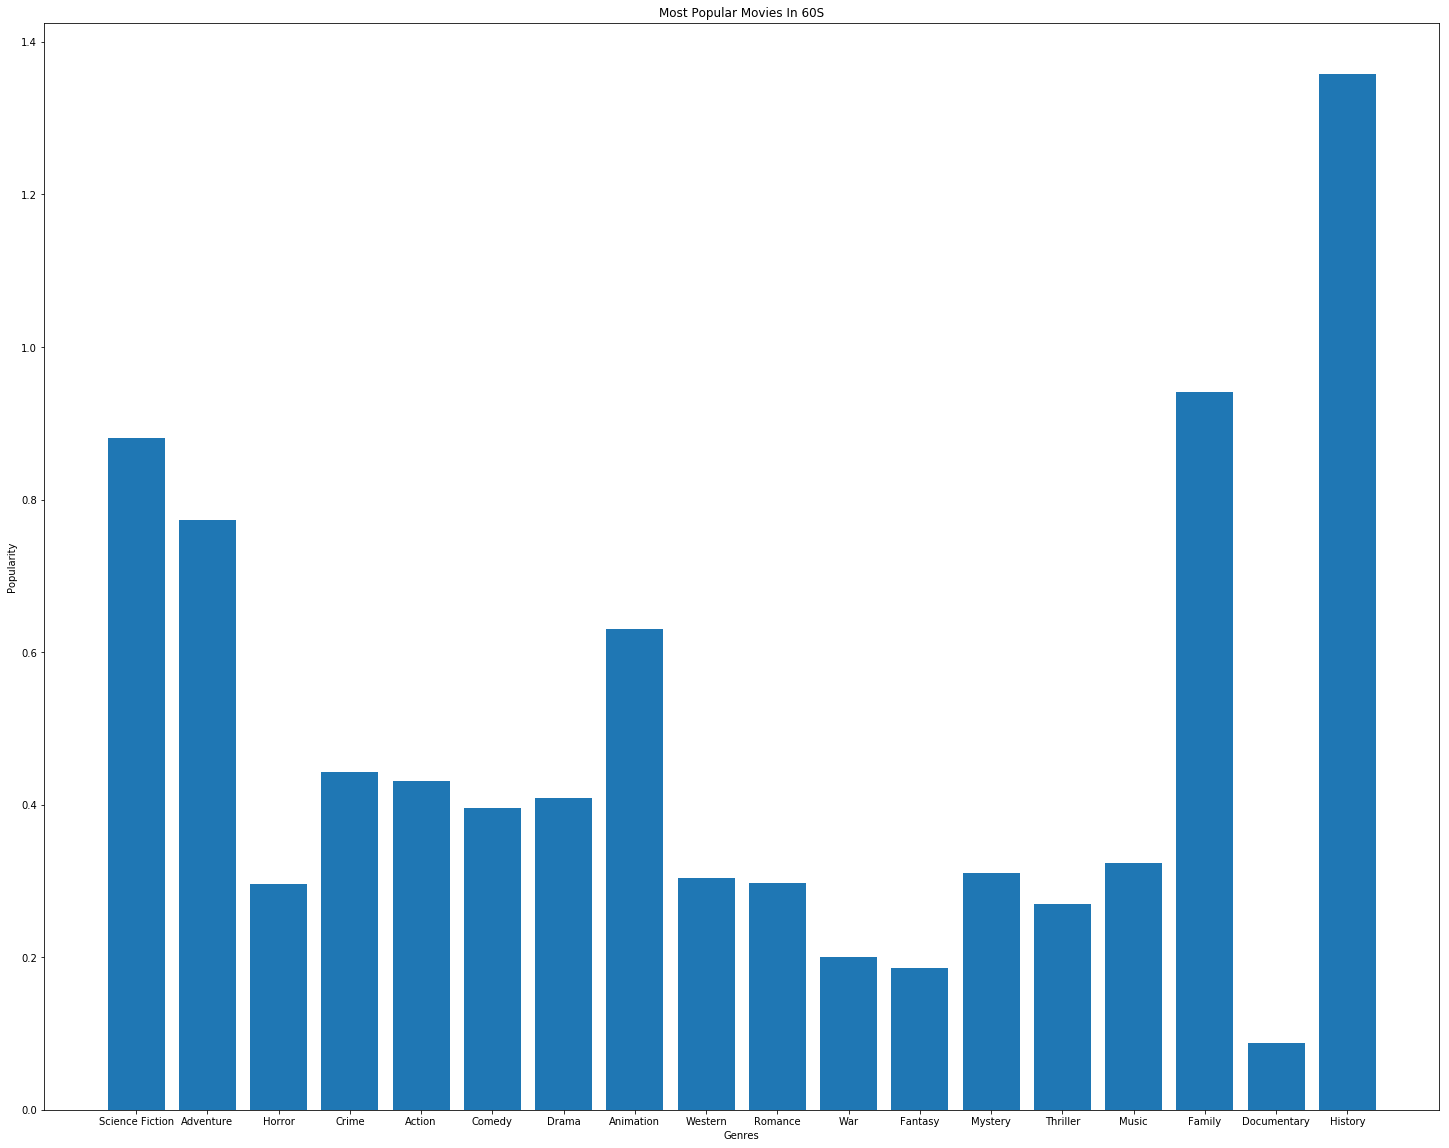

In [21]:
df_b = df_decade_60s[["main_genres", "popularity"]]
main_genres = df_decade_60s["main_genres"].unique()
pop = []
for g in main_genres:
    db = df_b[df_b['main_genres'] == g]
    pop.append(db["popularity"].mean())
plt.figure(figsize=(25, 20))    
plt.bar(range(len(pop)), pop, tick_label=main_genres)
plt.title('Most popular movies in 60s'.title())
plt.xlabel('Genres')
plt.ylabel('Popularity')


## It appears History movies have the highest Popularity in 60s

Text(0,0.5,'Popularity')

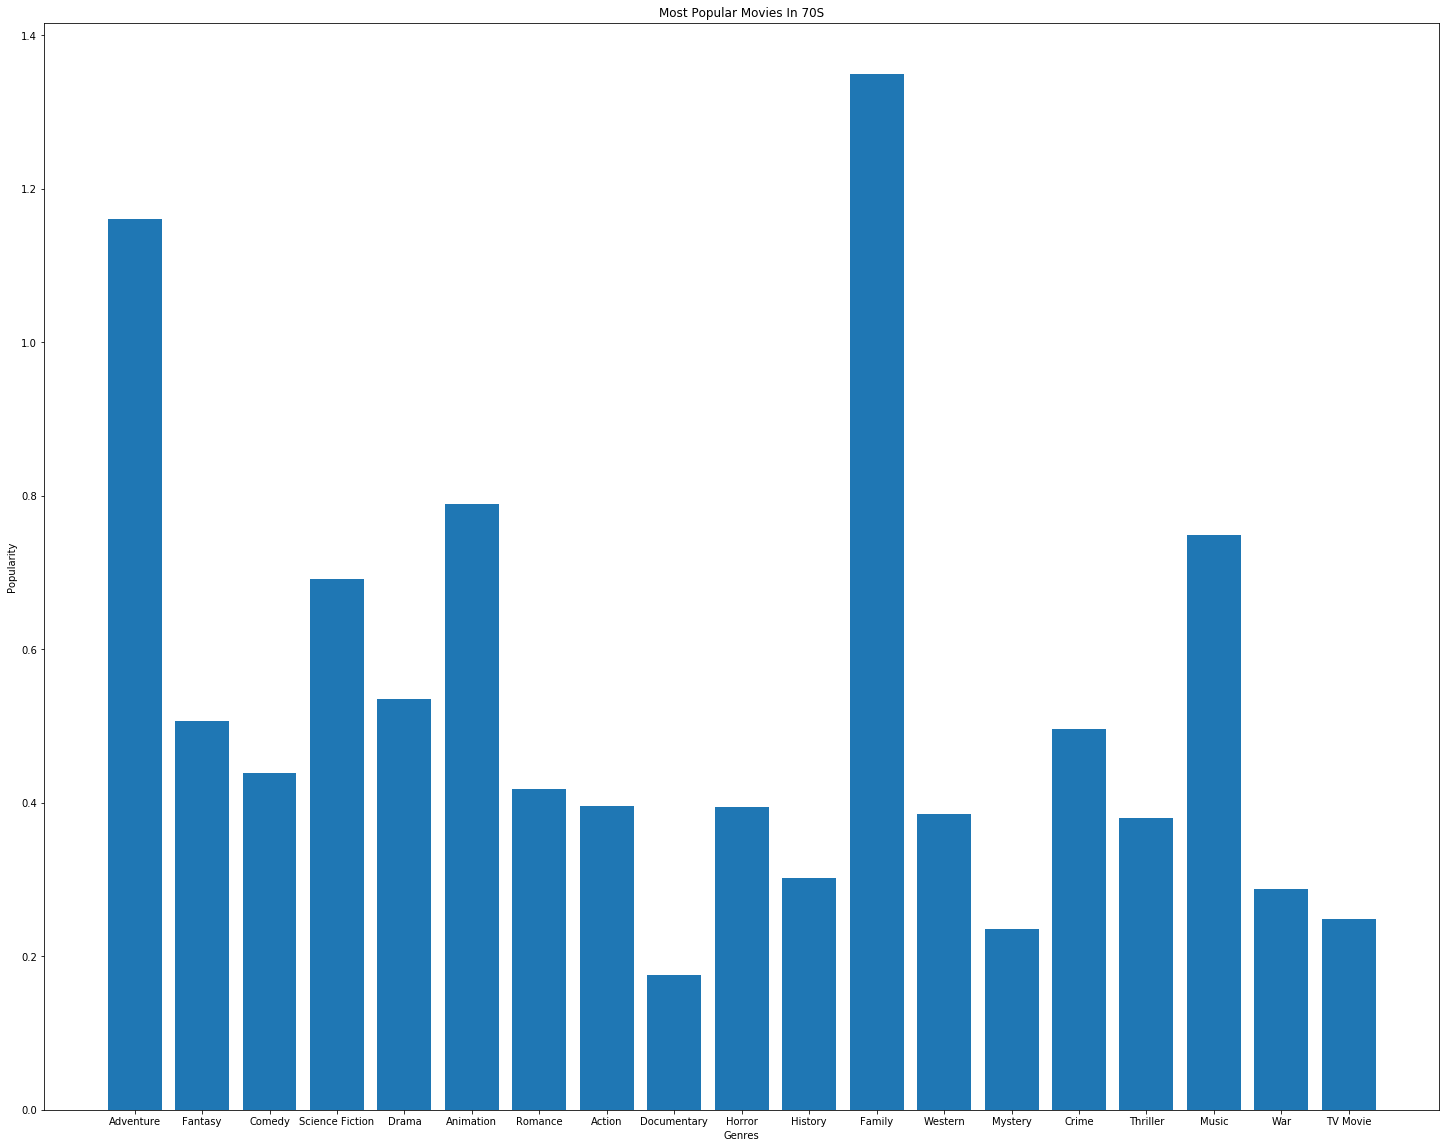

In [22]:
df_b = df_decade_70s[["main_genres", "popularity"]]
main_genres = df_decade_70s["main_genres"].unique()
pop = []
for g in main_genres:
    db = df_b[df_b['main_genres'] == g]
    pop.append(db["popularity"].mean())
plt.figure(figsize=(25, 20))    
plt.bar(range(len(pop)), pop, tick_label=main_genres)
plt.title('Most popular movies in 70s'.title())
plt.xlabel('Genres')
plt.ylabel('Popularity')


## It appears Family movies have the highest Popularity in 70s

Text(0,0.5,'Popularity')

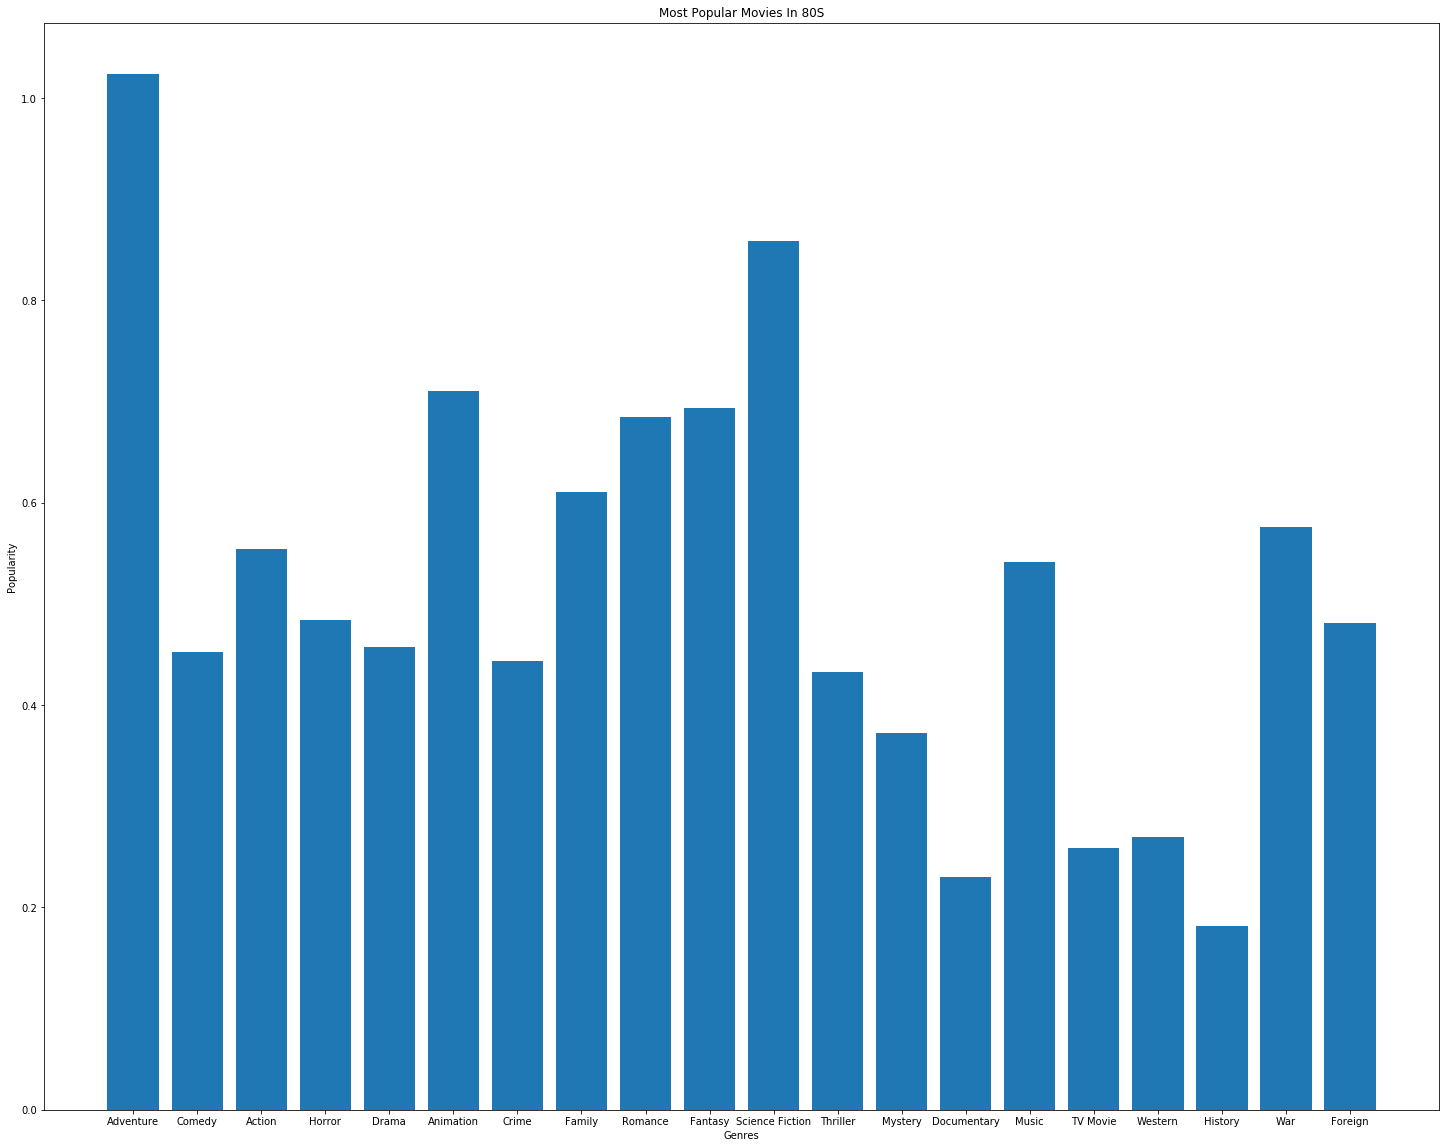

In [23]:
df_b = df_decade_80s[["main_genres", "popularity"]]
main_genres = df_decade_80s["main_genres"].unique()
pop = []
for g in main_genres:
    db = df_b[df_b['main_genres'] == g]
    pop.append(db["popularity"].mean())
plt.figure(figsize=(25, 20))    
plt.bar(range(len(pop)), pop, tick_label=main_genres)
plt.title('Most popular movies in 80s'.title())
plt.xlabel('Genres')
plt.ylabel('Popularity')


## It appears Adventure movies have the highest Popularity in 80s

Text(0,0.5,'Popularity')

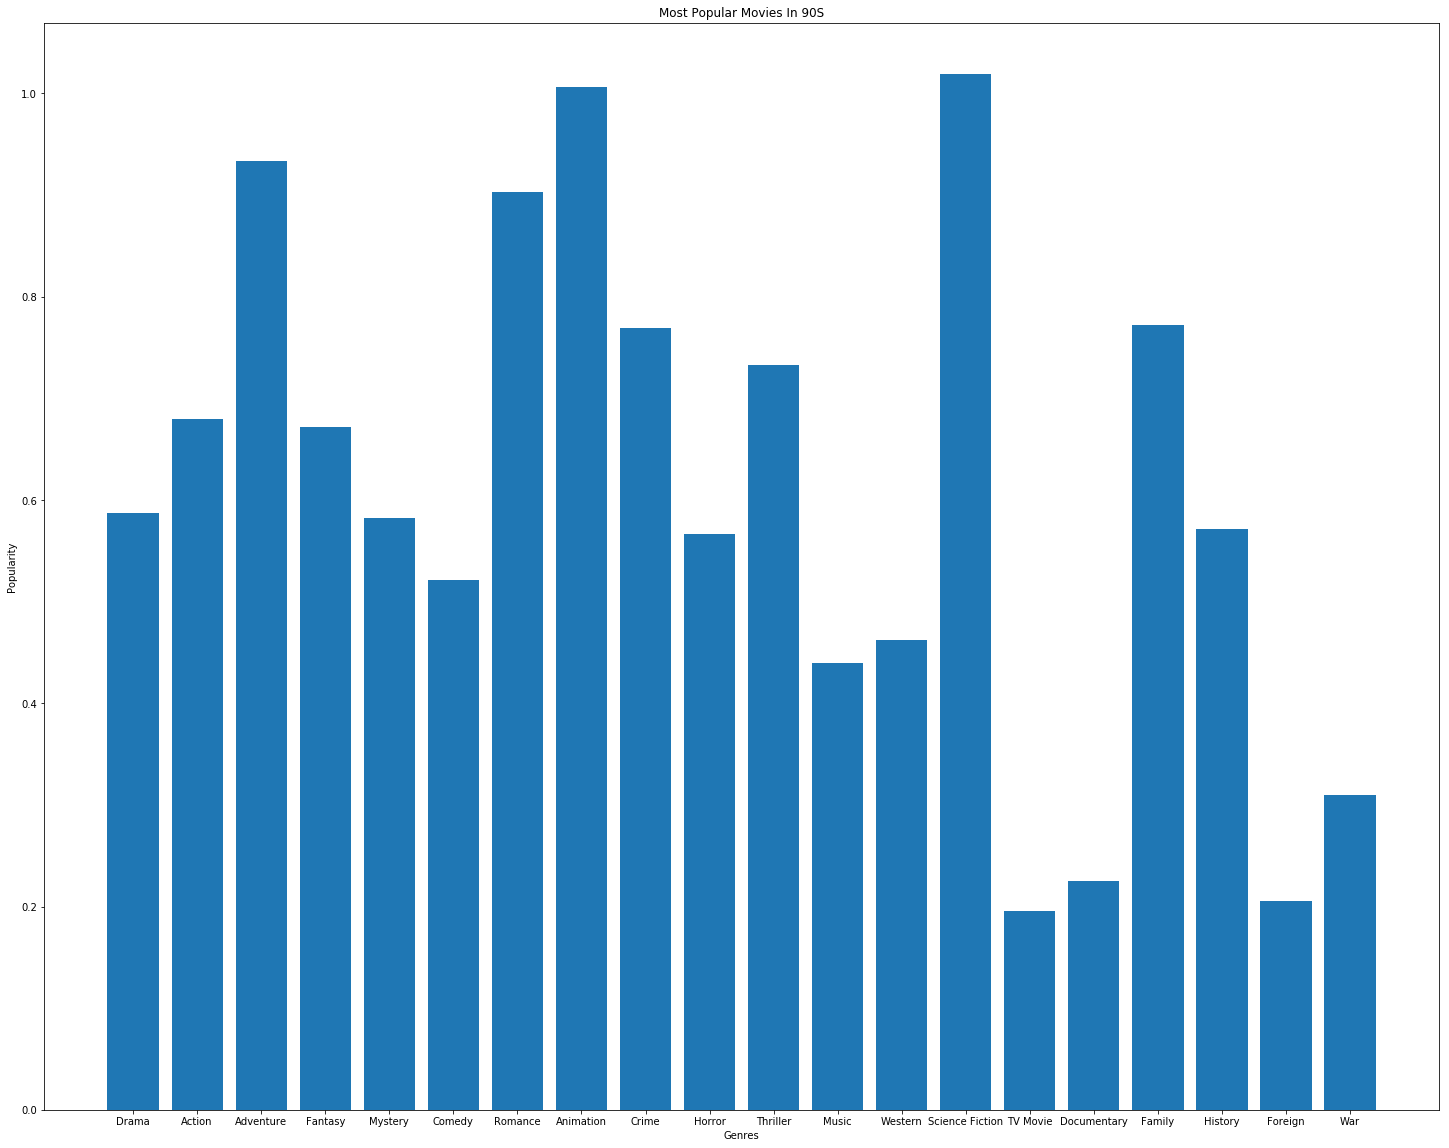

In [24]:
df_b = df_decade_90s[["main_genres", "popularity"]]
main_genres = df_decade_90s["main_genres"].unique()
pop = []
for g in main_genres:
    db = df_b[df_b['main_genres'] == g]
    pop.append(db["popularity"].mean())
plt.figure(figsize=(25, 20))    
plt.bar(range(len(pop)), pop, tick_label=main_genres)
plt.title('Most popular movies in 90s'.title())
plt.xlabel('Genres')
plt.ylabel('Popularity')


## It appears  Science Fiction movies have the highest Popularity in 90s

Text(0,0.5,'Popularity')

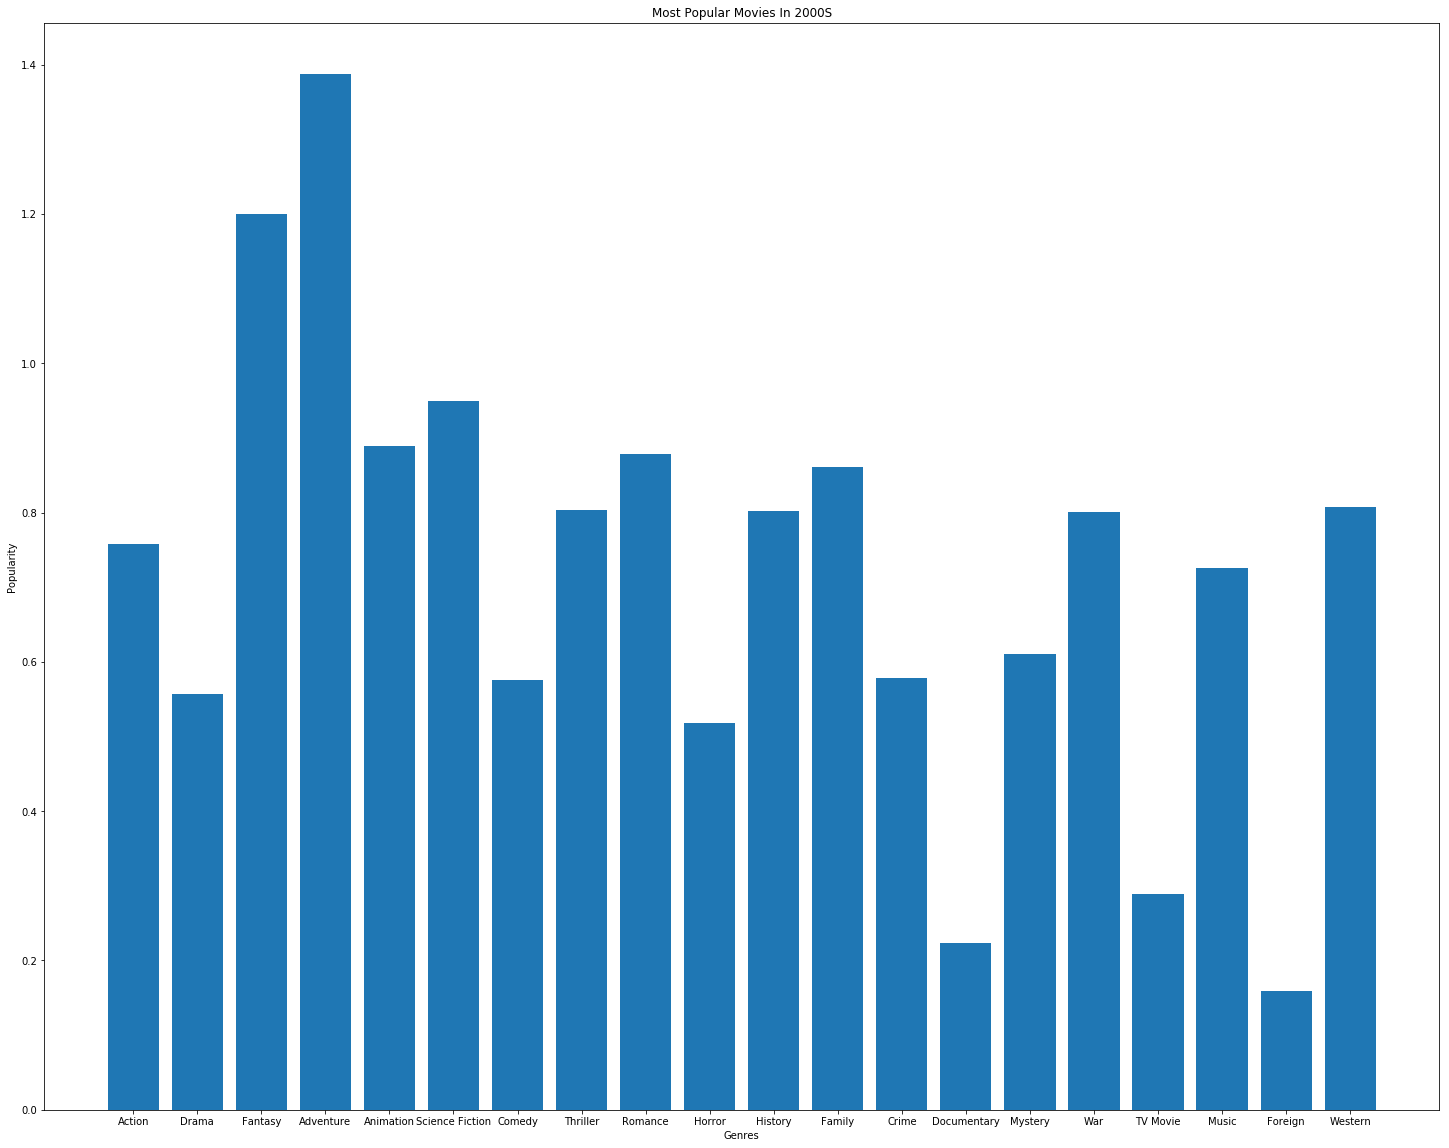

In [25]:
df_b = df_decade_2000s[["main_genres", "popularity"]]
main_genres = df_decade_2000s["main_genres"].unique()
pop = []
for g in main_genres:
    db = df_b[df_b['main_genres'] == g]
    pop.append(db["popularity"].mean())
plt.figure(figsize=(25, 20))    
plt.bar(range(len(pop)), pop, tick_label=main_genres)
plt.title('Most popular movies in 2000s'.title())
plt.xlabel('Genres')
plt.ylabel('Popularity')


## It appears  Adventure movies have the highest Popularity in 2000s

Text(0,0.5,'Popularity')

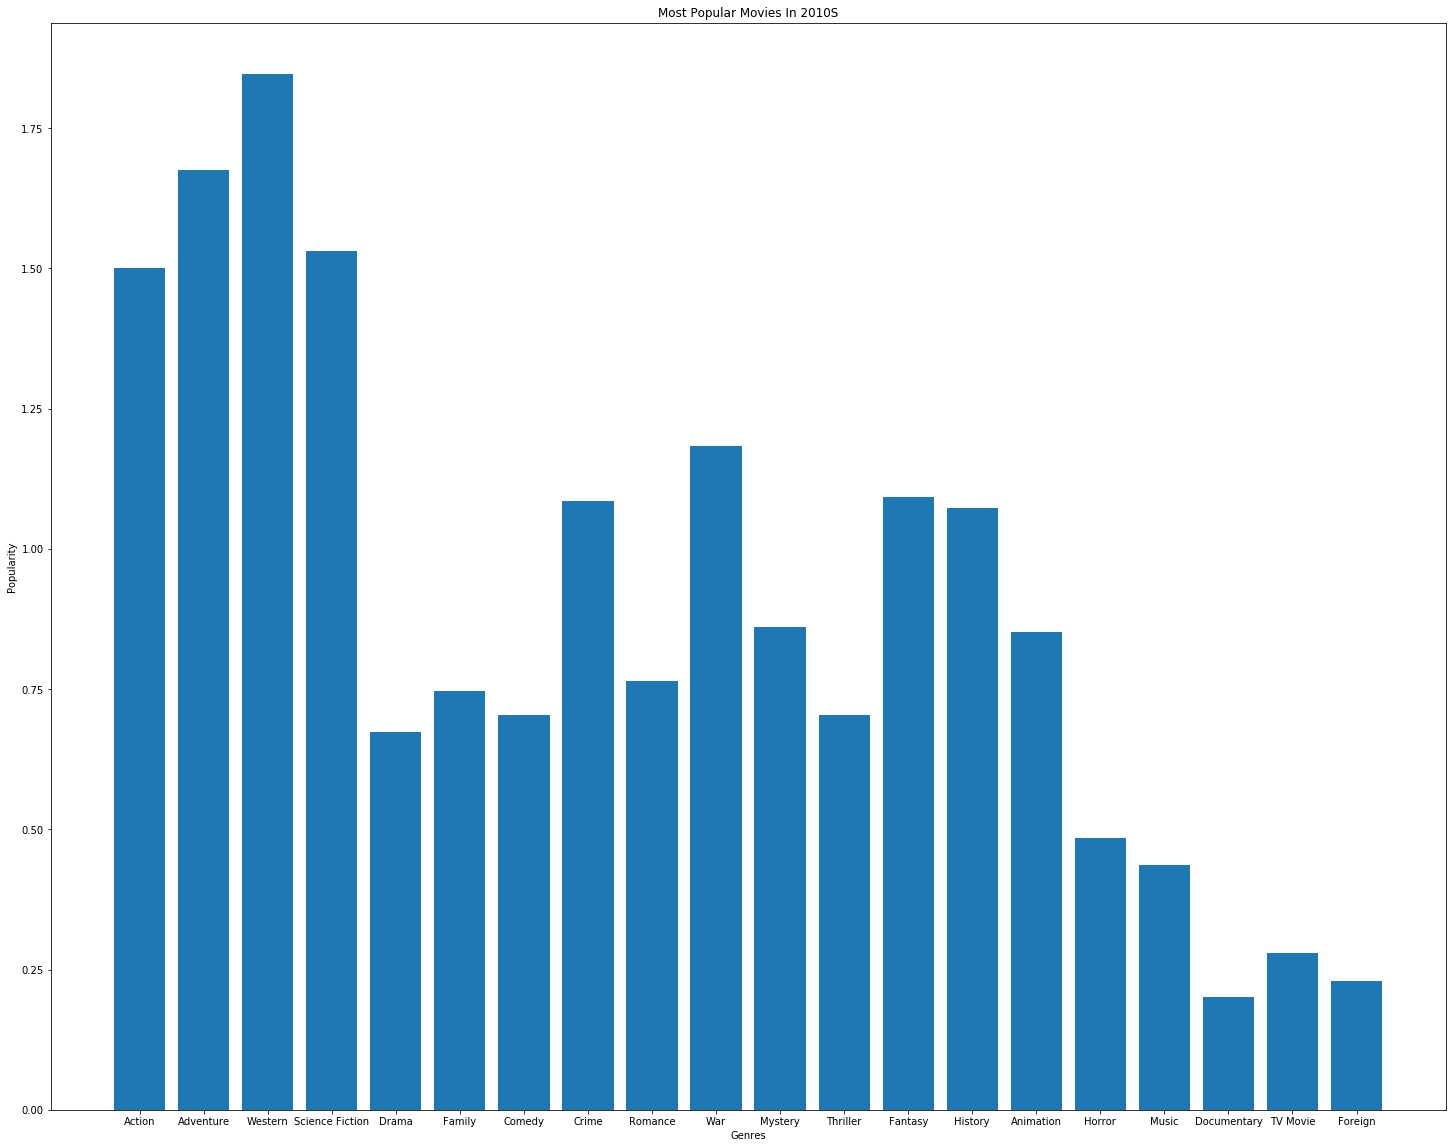

In [26]:
df_b = df_decade_2010s[["main_genres", "popularity"]]
main_genres = df_decade_2010s["main_genres"].unique()
pop = []
for g in main_genres:
    db = df_b[df_b['main_genres'] == g]
    pop.append(db["popularity"].mean())
plt.figure(figsize=(25, 20))    
plt.bar(range(len(pop)), pop, tick_label=main_genres)
plt.title('Most popular movies in 2010s'.title())
plt.xlabel('Genres')
plt.ylabel('Popularity')


## It appears Westren movies have the highest Popularity in 2010s

### What kinds of properties are associated with movies that have high revenues?

In [27]:
# Continue to explore the data to address your additional research
#   questions. Add more headers as needed if you have more questions to
#   investigate.
df_sorted = df.sort_values("revenue" ,ascending=False)
high_100_r = df_sorted.head(100)


#### Relation Retween Ratings and Revenue

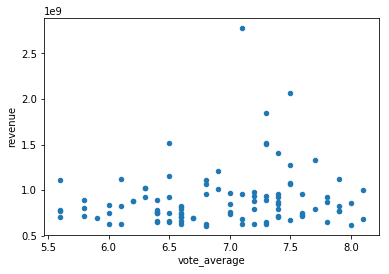

In [28]:
high_100_r.plot(x="vote_average", y="revenue", kind="scatter")

## It appears There is no correlation between ratings and revenue

Text(0,0.5,'Revenue Avarge')

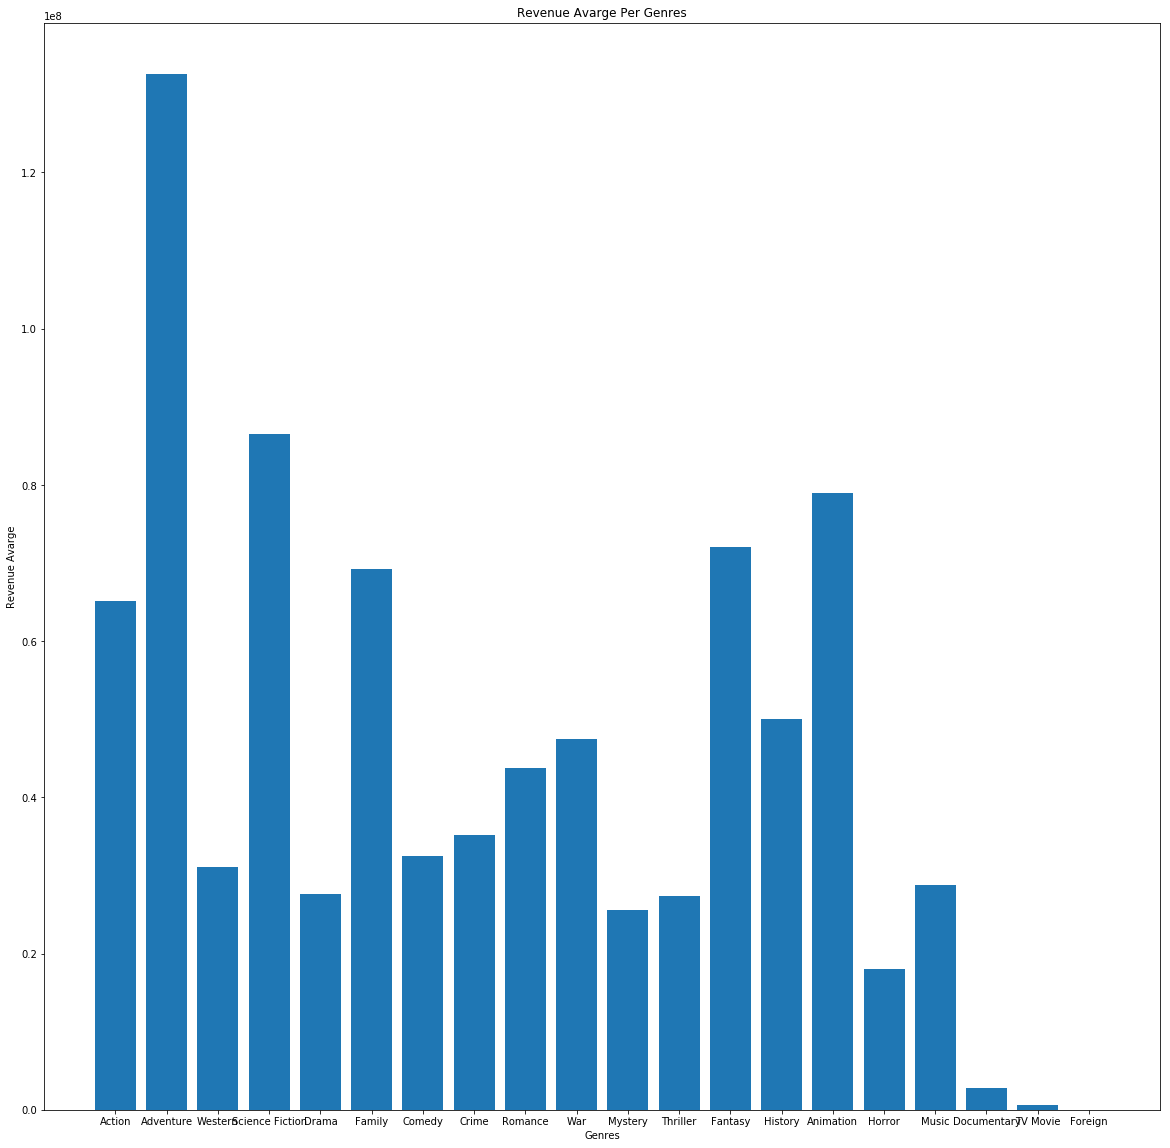

In [29]:
main_genres = df["main_genres"].unique()
pop = []
for g in main_genres:
    db = df[df['main_genres'] == g]
    pop.append(db["revenue"].mean())
plt.figure(figsize=(20, 20))    
plt.bar(range(len(pop)), pop, tick_label=main_genres)
plt.title('Revenue avarge per Genres'.title())
plt.xlabel('Genres')
plt.ylabel('Revenue Avarge')

### It appears  Adventure movies have the highest Revenue of all time

<a id='conclusions'></a>
## Conclusions

> **Tip**: Finally, summarize your findings and the results that have been performed in relation to the question(s) provided at the beginning of the analysis. Summarize the results accurately, and point out where additional research can be done or where additional information could be useful.


> **Tip**: If you haven't done any statistical tests, do not imply any statistical conclusions. And make sure you avoid implying causation from correlation!

### Limitations
> **Tip**: Make sure that you are clear with regards to the limitations of your exploration. You should have at least 1 limitation explained clearly. 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the rubric (found on the project submission page at the end of the lesson). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.

## Submitting your Project 

> **Tip**: Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> **Tip**: Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> **Tip**: Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [30]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])

0